In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid',palette='muted')
from pylab import rcParams
rcParams['figure.figsize'] = 16,10


In [2]:
df = pd.read_csv('df_ready.csv',index_col = ('Date','Time'))
df.head() #the index is pointless anyway

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
10/03/2004 18.00.00  0.955511       1360.0  2.476538         1046.0  5.111988   
           19.00.00  0.693147       1292.0  2.240710          955.0  4.634729   
           20.00.00  0.788457       1402.0  2.197225          939.0  4.875197   
           21.00.00  0.788457       1376.0  2.219203          948.0  5.147494   
           22.00.00  0.470004       1272.0  1.871802          836.0  4.875197   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Date       Time                                                               
10/03/2004 18.00.00        1056.0    113.0        1692.0       1268.0  13.6   
           19.00.00        1174.0     92.0        1559.0        972.0  13.3   
           20.00.00        1140.0    114.0        1555.0       1074.0  11.9   
           21.00.00        1092.0    122.0        1584.0       1203.0  11.0   
           22.00.00        1205.0    116.0        1490.0       1110.0  11.2   

                         AH  target  
Date       Time                      
10/03/2004 18.00.00  0.7578    48.9  
           19.00.00  0.7255    47.7  
           20.00.00  0.7502    54.0  
           21.00.00  0.7867    60.0  
           22.00.00  0.7888    59.6

## Task nr.1 - get a proper prediction for the next 1 day

In this case let's aim for 1 day for starters.
I need to get rid of the first and last day since the data is incomplete.
Then I need to get sequences of 24 entries (a day) and corresponding sequences of ys.
Also I should not forget that I should leave out the last day as that's the subject of my prediction.
Reminder: the X should have a shape of N, Timesteps, D where D are the variables.

In [3]:
df.tail()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
04/04/2005 10.00.00  1.131402       1314.0  2.602690         1101.0  6.156979   
           11.00.00  0.875469       1163.0  2.433613         1027.0  5.866468   
           12.00.00  0.875469       1142.0  2.517696         1063.0  5.680173   
           13.00.00  0.741937       1003.0  2.251292          961.0  5.459586   
           14.00.00  0.788457       1071.0  2.476538         1047.0  5.579730   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Date       Time                                                               
04/04/2005 10.00.00         539.0    190.0        1374.0       1729.0  21.9   
           11.00.00         604.0    179.0        1264.0       1269.0  24.3   
           12.00.00         603.0    175.0        1241.0       1092.0  26.9   
           13.00.00         702.0    156.0        1041.0        770.0  28.3   
           14.00.00         654.0    168.0        1129.0        816.0  28.5   

                         AH  target  
Date       Time                      
04/04/2005 10.00.00  0.7568    29.3  
           11.00.00  0.7119    23.7  
           12.00.00  0.6406    18.3  
           13.00.00  0.5139    13.5  
           14.00.00  0.5028    13.1

In [4]:
#okay so I need to get rid of the first 6 (0:00 is already next day?) and last 15 rows
df1 = df.copy()
df = df[6:-15]


In [5]:
df.head()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
11/03/2004 00.00.00  0.182322       1185.0  1.280934          690.0  4.127134   
           01.00.00  0.000000       1136.0  1.193922          672.0  4.127134   
           02.00.00 -0.105361       1094.0  0.832909          609.0  3.806662   
           03.00.00 -0.510826       1010.0  0.530628          561.0  3.496508   
           04.00.00 -0.430783       1011.0  0.262364          527.0  3.044522   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Date       Time                                                               
11/03/2004 00.00.00        1462.0     77.0        1333.0        733.0  11.3   
           01.00.00        1453.0     76.0        1333.0        730.0  10.7   
           02.00.00        1579.0     60.0        1276.0        620.0  10.7   
           03.00.00        1705.0     47.0        1235.0        501.0  10.3   
           04.00.00        1818.0     34.0        1197.0        445.0  10.1   

                         AH  target  
Date       Time                      
11/03/2004 00.00.00  0.7603    56.8  
           01.00.00  0.7702    60.0  
           02.00.00  0.7648    59.7  
           03.00.00  0.7517    60.2  
           04.00.00  0.7465    60.5

In [6]:
df.tail()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
03/04/2005 19.00.00  0.993252       1248.0  2.406945         1018.0  5.905362   
           20.00.00  0.916291       1180.0  2.066863          894.0  5.872118   
           21.00.00  0.405465       1102.0  1.791759          812.0  5.459586   
           22.00.00  0.470004       1116.0  1.757858          803.0  5.451038   
           23.00.00  0.182322       1100.0  1.629241          769.0  5.135798   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Date       Time                                                               
03/04/2005 19.00.00         599.0    181.0        1289.0       1167.0  19.9   
           20.00.00         636.0    187.0        1200.0       1372.0  17.5   
           21.00.00         693.0    158.0        1178.0       1042.0  16.4   
           22.00.00         696.0    153.0        1173.0       1055.0  15.5   
           23.00.00         722.0    128.0        1147.0       1049.0  14.3   

                         AH  target  
Date       Time                      
03/04/2005 19.00.00  0.7608    33.0  
           20.00.00  0.8073    40.7  
           21.00.00  0.8642    46.6  
           22.00.00  0.8579    49.0  
           23.00.00  0.8497    52.5

seems about right, now I need to scale the data first and save the scaler for later use

In [7]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler_y = RobustScaler()
temp_targets = df.pop('target')
scaled_values = scaler.fit_transform(df)
scaled_targets = scaler_y.fit_transform(np.array(temp_targets).reshape(-1,1))
df_scaled = pd.DataFrame(scaled_values, columns = df.columns)
df_scaled['target'] = scaled_targets
df_scaled.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,target
0,-0.418264,0.391701,-0.731393,-0.572917,-0.871803,2.102236,-0.463148,-0.287982,-0.423025,-0.500000,-0.400313,0.271698
1,-0.606340,0.229046,-0.807578,-0.619792,-0.871803,2.073482,-0.479780,-0.287982,-0.428380,-0.547619,-0.383115,0.392453
2,-0.715027,0.089627,-1.123675,-0.783854,-1.133937,2.476038,-0.745892,-0.417234,-0.624721,-0.547619,-0.392496,0.381132
3,-1.133290,-0.189212,-1.388347,-0.908854,-1.387633,2.878594,-0.962109,-0.510204,-0.837126,-0.579365,-0.415252,0.400000
4,-1.050721,-0.185892,-1.623234,-0.997396,-1.757340,3.239617,-1.178325,-0.596372,-0.937082,-0.595238,-0.424285,0.411321


In [8]:
test = df_scaled[-24:]
df = df_scaled[:-24]

In [9]:
test

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,target
9312,-0.836527,-0.458091,-1.050668,-0.763021,-0.205566,0.476038,-0.047348,-1.274376,-0.760375,-0.325397,-0.723064,-0.460377
9313,-0.836527,-0.385062,-0.951439,-0.697917,-0.410298,0.290735,-0.313460,-1.204082,-0.542615,-0.388889,-0.682764,-0.332075
9314,-0.974274,-0.428216,-0.983282,-0.726562,-0.489009,0.249201,-0.463148,-1.199546,-0.519411,-0.444444,-0.648022,-0.203774
9315,-0.836527,-0.484647,-0.951439,-0.697917,-0.331655,0.182109,-0.280196,-1.160998,-0.360553,-0.563492,-0.650280,-0.033962
9316,-1.321367,-0.720332,-1.246048,-0.851562,-0.633198,0.482428,-0.679364,-1.238095,-0.680054,-0.595238,-0.657576,0.003774
9317,-1.848317,-0.849793,-1.852955,-1.083333,-0.898624,1.003195,-0.978741,-1.333333,-0.892459,-0.634921,-0.664524,0.052830
9318,-1.551554,-0.726971,-1.623234,-0.989583,-0.716101,0.856230,-0.829053,-1.267574,-0.797858,-0.674603,-0.665914,0.105660
9319,-1.133290,-0.614108,-1.388347,-0.903646,-0.285281,0.555911,-0.346724,-1.188209,-0.553324,-0.690476,-0.672862,0.116981
9320,-0.974274,-0.434855,-1.086411,-0.778646,-0.241395,0.341853,-0.263564,-1.158730,-0.408746,-0.325397,-0.649585,-0.362264
9321,-0.418264,-0.149378,-0.617520,-0.507812,0.052790,0.006390,0.218765,-1.034014,-0.248104,0.015873,-0.643158,-0.713208


In [10]:
#from the last one I only need the targets actually
y_test = test.iloc[:,-1].to_numpy()

In [11]:
y_test

array([-0.46037736, -0.33207547, -0.20377358, -0.03396226,  0.00377358,
        0.05283019,  0.10566038,  0.11698113, -0.36226415, -0.71320755,
       -0.97735849, -1.14339623, -1.25283019, -1.35471698, -1.37735849,
       -1.45283019, -1.47924528, -1.49811321, -1.05283019, -0.62641509,
       -0.33584906, -0.11320755, -0.02264151,  0.10943396])

In [12]:
# now to get the corresponding X_test

In [13]:
X_test = df.iloc[-24:,:-1]

In [14]:
X_test

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH
9288,-0.188077,-0.338589,-0.313807,-0.278646,0.361403,-0.006390,1.150157,-1.154195,-0.144578,-0.357143,-0.884266
9289,-0.508022,-0.760166,-1.290960,-0.859375,-0.061317,0.801917,0.368453,-1.517007,-0.810353,-0.388889,-0.869501
9290,-1.133290,-0.770124,-1.497937,-0.947917,-0.464590,0.980831,-0.396620,-1.569161,-1.033467,-0.428571,-0.845877
9291,-1.321367,-0.819917,-1.558346,-0.973958,-0.548991,1.063898,-0.579572,-1.548753,-1.063811,-0.452381,-0.862032
9292,-1.551554,-0.836515,-1.945207,-1.098958,-0.858716,1.338658,-0.928845,-1.628118,-1.149487,-0.507937,-0.835280
9293,-1.551554,-0.746888,-1.558346,-0.976562,-0.912372,1.073482,-1.012005,-1.485261,-1.103079,-0.523810,-0.797585
9294,-1.133290,-0.607469,-1.246048,-0.841146,-0.081147,0.623003,0.035812,-1.353741,-0.721107,-0.547619,-0.767534
9295,-0.715027,-0.481328,-0.862320,-0.656250,0.189762,0.300319,0.601301,-1.219955,-0.471218,-0.515873,-0.727407
9296,-0.715027,-0.544398,-1.050668,-0.760417,0.013520,0.412141,0.268661,-1.272109,-0.705042,-0.269841,-0.689365
9297,-0.836527,-0.557676,-0.983282,-0.726562,-0.176863,0.482428,-0.030716,-1.306122,-0.829987,-0.158730,-0.702914


Keep in mind that I need i:24 Xs and corresponding i+24:2*24 ys

In [15]:
## SEQUENCING FUNCTION
#the output should be N x 24 x 11

def sequencer24(X,hours = 24):
    XX = X.iloc[:-hours,:-1].values
    yy = X.iloc[hours:,-1].to_numpy() #25 inc.
    XX = np.array(np.split(XX,len(XX)/hours))
    yy = np.array(np.split(yy,len(yy)/hours))
    return XX, yy[:,:,np.newaxis]

In [16]:
X_train, y_train = sequencer24(df)

In [17]:
X_train.shape

(387, 24, 11)

In [18]:
y_train.shape

(387, 24, 1)

At this point the data IS NOT overlapping, thus we only have full days and full next days' targets. Will this work?

In [19]:
def train_gru(X,y,lr=0.001):
    model = keras.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=X_train[0].shape),
        keras.layers.GRU(20),
        keras.layers.Dense(24)
    ])
    adam = keras.optimizers.Adam(lr)
    ES = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience = 2)
    model.compile(loss='mse',optimizer=adam,metrics = [tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(X, y, epochs = 50, validation_split = 0.1, callbacks = [ES], batch_size=32,
                       shuffle = False, verbose=1)

    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label = 'Training loss')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'Validation loss')
    plt.title('RMSE')
    plt.legend()
    plt.show()
    
    return model

Epoch 1/50
11/11 [==============================] - 1s 60ms/step - loss: 0.4281 - root_mean_squared_error: 0.6543 - val_loss: 0.4275 - val_root_mean_squared_error: 0.6538
Epoch 2/50
11/11 [==============================] - 0s 17ms/step - loss: 0.3904 - root_mean_squared_error: 0.6248 - val_loss: 0.3992 - val_root_mean_squared_error: 0.6318
Epoch 3/50
11/11 [==============================] - 0s 12ms/step - loss: 0.3640 - root_mean_squared_error: 0.6034 - val_loss: 0.3711 - val_root_mean_squared_error: 0.6092
Epoch 4/50
11/11 [==============================] - 0s 12ms/step - loss: 0.3412 - root_mean_squared_error: 0.5841 - val_loss: 0.3453 - val_root_mean_squared_error: 0.5876
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 0.3210 - root_mean_squared_error: 0.5665 - val_loss: 0.3235 - val_root_mean_squared_error: 0.5688
Epoch 6/50
11/11 [==============================] - 0s 12ms/step - loss: 0.3028 - root_mean_squared_error: 0.5503 - val_loss: 0.3060 - val_root_m

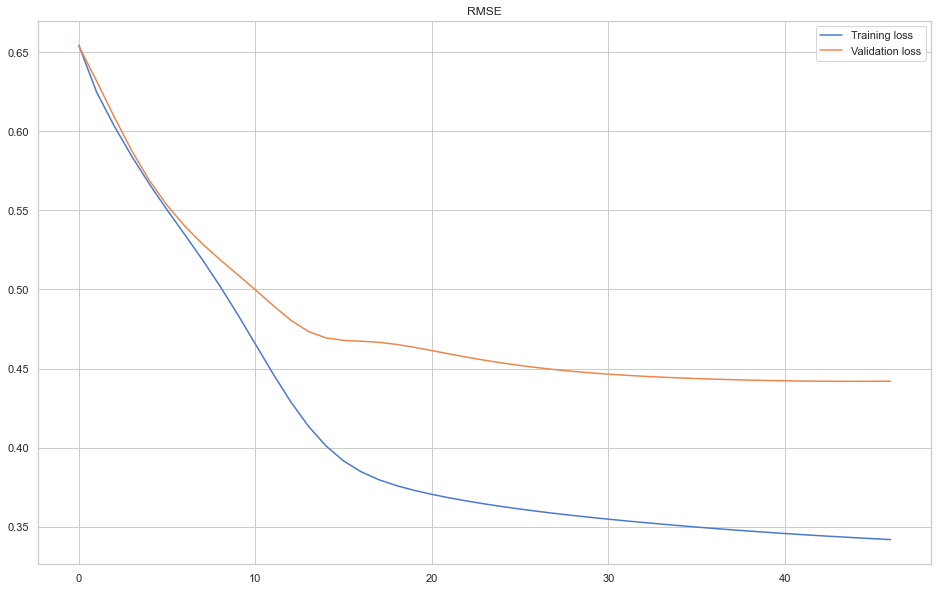

In [20]:
model1 = train_gru(X_train, y_train)

In [21]:
print(X_test.shape, y_test.shape)

(24, 11) (24,)


In [22]:
X_test = X_test.values[np.newaxis,:,:]

In [23]:
X_test.shape

(1, 24, 11)

In [24]:
pred = model1.predict(X_test)

In [25]:
pred

array([[-0.51638496, -0.5557164 , -0.5075238 , -0.2892056 , -0.28358397,
        -0.29346216, -0.30617827, -0.3560588 , -0.385511  , -0.5179975 ,
        -0.5529647 , -0.8498683 , -0.7905105 , -0.87231493, -0.7728371 ,
        -0.77877325, -0.8148284 , -0.8095324 , -0.639977  , -0.5731526 ,
        -0.46002352, -0.49189326, -0.44754073, -0.3159989 ]],
      dtype=float32)

In [26]:
true_eval = pred.flatten()

In [28]:
testing_y = scaler_y.inverse_transform(y_test.reshape(-1,1))
predicted_y = scaler_y.inverse_transform(true_eval.reshape(-1,1))

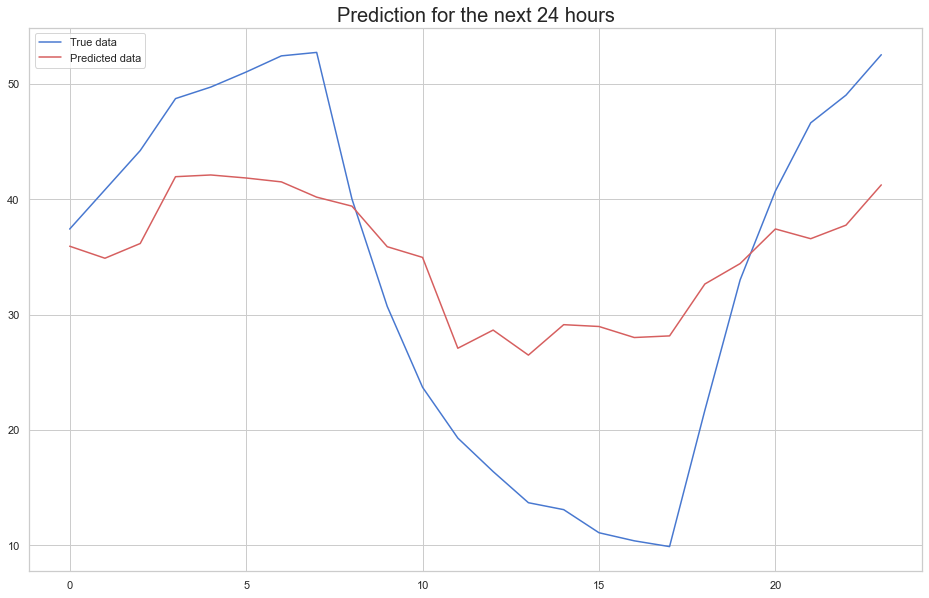

In [33]:
plt.plot(testing_y.flatten(),label='True data')
plt.plot(predicted_y.flatten(),'r',label='Predicted data')
plt.legend()
plt.title('Prediction for the next 24 hours', fontsize = 20)
plt.show()

## CONCLUSION

So this is how the multistep prediction is done - the model needs to be ready for it. The performance is not stunning, BUT it shows some generalization and actually follows the trend up to a certain level. This has been a crucial experience for me. Later I will try to make the prediction more accurate by adding more models and tweaking the HP more. 